# Model Building

## Setup & Load Data

In [1]:
# Model Building & Selection
# We compare baseline models and select the best one based on recall for churners (minority class).
# Final model: SVC with class weights, probability enabled, and light hyperparameter tuning.

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load processed data
X_train = pd.read_csv('../data/processed/X_train_processed.csv')
X_test = pd.read_csv('../data/processed/X_test_processed.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Churn rate in test: {y_test.mean():.3f}")

Train shape: (8000, 11), Test shape: (2000, 11)
Churn rate in test: 0.203


In [3]:
# Baseline Model Comparison
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200),
    "SVC": SVC(class_weight='balanced', probability=True, random_state=42)  # probability=True is key!
}

In [4]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        "recall_churn": report['1']['recall'],
        "precision_churn": report['1']['precision'],
        "f1_churn": report['1']['f1-score'],
        "auc": auc
    }
    
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {auc:.4f}" if auc != "N/A" else "ROC-AUC: N/A")


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000

ROC-AUC: 0.7771

===== Random Forest =====
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.77      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000

ROC-AUC: 0.8540

===== SVC =====
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.49      0.74      0.59       407

    accuracy                           0.79      2000
   macro avg       

In [5]:
# Hyperparameter Tuning for SVC (RBF kernel by default)
print("\nStarting GridSearchCV for SVC...")
param_grid = {
    'C': [0.5, 1, 2, 5, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

svc_grid = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

svc_grid.fit(X_train, y_train)

print("Best parameters:", svc_grid.best_params_)
print("Best cross-validated recall:", svc_grid.best_score_)


Starting GridSearchCV for SVC...
Best parameters: {'C': 0.5, 'gamma': 0.1}
Best cross-validated recall: 0.7509202453987729


In [6]:
# Final model = best from grid search
final_model = svc_grid.best_estimator_

# Evaluate final tuned model
y_pred_final = final_model.predict(X_test)
y_prob_final = final_model.predict_proba(X_test)[:, 1]

print("\n===== Final Tuned SVC =====")
print(classification_report(y_test, y_pred_final))
print(f"Final ROC-AUC: {roc_auc_score(y_test, y_prob_final):.4f}")


===== Final Tuned SVC =====
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1593
           1       0.50      0.74      0.60       407

    accuracy                           0.80      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.80      0.81      2000

Final ROC-AUC: 0.8594



Computing permutation importance...


C:\Users\piyus\AppData\Local\Temp\ipykernel_27772\541506656.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


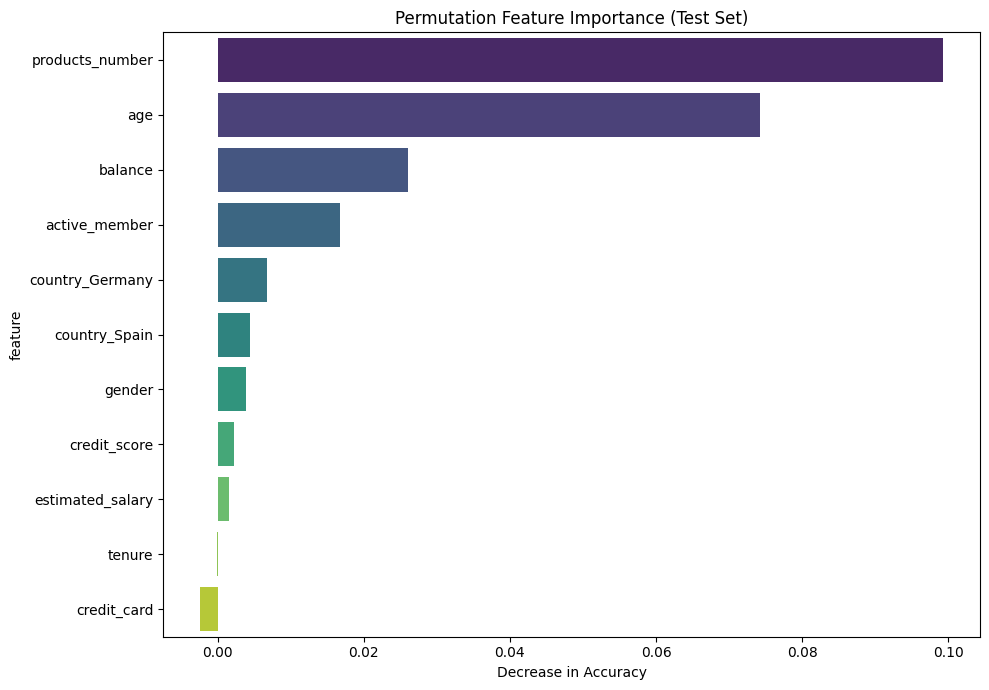


Feature Importance Ranking:
             feature  importance
5    products_number     0.09925
2                age     0.07425
4            balance     0.02605
7      active_member     0.01680
9    country_Germany     0.00675
10     country_Spain     0.00450
1             gender     0.00385
0       credit_score     0.00220
8   estimated_salary     0.00155
3             tenure    -0.00010
6        credit_card    -0.00235


In [7]:
# Permutation Feature Importance
print("\nComputing permutation importance...")
perm_importance = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Permutation Feature Importance (Test Set)')
plt.xlabel('Decrease in Accuracy')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(importance_df)

In [8]:
# Save final model (now supports predict_proba!)
joblib.dump(final_model, '../models/model.pkl')
print("\nFinal tuned model saved to ../models/model.pkl (with predict_proba enabled)")


Final tuned model saved to ../models/model.pkl (with predict_proba enabled)


## Model Choosing

Choosing SVC as the final model, because our churn datasets is **imbalanced** (majority non-churners).

In this scenario:

* Accuracy becomes misleading
* The focus shifts to the positive class (**churners**)
* Missing churners introduces **high business risk**

**SVC provided the best recall and F1-score for churners**, meaning it identifies the highest number of true churners.

This aligns with the project objective: **prioritize detecting churners even if it introduces slightly more false positives.**

Thus, **SVC was selected as the recommended model**.